In [1]:
%pip install geopandas libpysal esda

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import Queen
import numpy as np
from esda.moran import Moran
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

In [3]:
ufs = ['RS', 'SC', 'PR']

In [4]:
# Leitura dos shapefiles de cada estado
rs = gpd.read_file("shapefiles/RS_Municipios_2024.shp").to_crs(epsg=4326)
sc = gpd.read_file("shapefiles/SC_Municipios_2024.shp").to_crs(epsg=4326)
pr = gpd.read_file("shapefiles/PR_Municipios_2024.shp").to_crs(epsg=4326)

# Unifica os três GeoDataFrames
cidades_sul = gpd.GeoDataFrame(pd.concat([rs, sc, pr], ignore_index=True), crs="EPSG:4326")

In [5]:
cidades_sul = cidades_sul.rename(columns={"NM_MUN": "municipio"})

In [6]:
cidades_sul.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry
0,4316204,Rondinha,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,252.454,"POLYGON ((-52.91535 -27.88582, -52.91559 -27.8..."
1,4317558,Santo Antônio do Palma,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,126.094,"POLYGON ((-51.99835 -28.43782, -51.99822 -28.4..."
2,4319307,São Paulo das Missões,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,Sul,S,None,None,222.504,"POLYGON ((-54.93828 -28.05575, -54.96888 -28.0..."
3,4311429,Lajeado do Bugre,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,67.947,"POLYGON ((-53.15215 -27.69941, -53.15493 -27.7..."
4,4318002,São Borja,430017,São Borja,4304,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,None,None,3616.674,"POLYGON ((-56.08158 -28.85668, -56.08628 -28.8..."


# Matriz de vizinhança

In [7]:
cidades = cidades_sul.to_crs(epsg=31982)  # ou o EPSG adequado à sua região

# Criar matriz de vizinhança do tipo Queen (vizinhos que tocam qualquer ponto da fronteira)
w = Queen.from_dataframe(cidades)

# Ver quantos vizinhos cada município tem
print(w.neighbors)

# Exemplo: vizinhos do município no índice 0
print("Vizinhos do município 0:", w.neighbors[0])

C:\Users\adria\AppData\Local\Temp\ipykernel_16044\420671325.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(cidades)


{0: [434, 54, 167, 408, 460], 1: [243, 229, 329, 394, 348, 9], 2: [16, 85, 39, 46, 313, 382], 3: [418, 370, 20, 103, 141], 4: [224, 442, 275, 249, 106, 13], 5: [407, 488, 393, 441, 332, 478], 6: [315, 135, 267, 412, 94, 303], 7: [230, 455, 105, 218, 348, 270], 8: [230, 105, 363, 336, 433, 84, 473, 218], 9: [1, 98, 243, 470, 329], 10: [96, 194, 150, 474, 396, 29, 351], 11: [193, 418, 25, 154, 187, 141, 31], 12: [357, 486, 245, 475, 235, 431], 13: [106, 4, 183], 14: [208, 81, 58, 125], 15: [144, 148, 293, 55, 56, 457, 383], 16: [89, 2, 382, 46], 17: [33, 296, 362, 45, 205, 179, 55, 345], 18: [448, 427, 388], 19: [186, 105, 482, 229], 20: [241, 418, 3, 103, 314], 21: [393, 66, 30, 407], 22: [46, 462, 183], 23: [593, 436, 325, 341, 597, 349, 271], 24: [468, 117, 118, 200, 286], 25: [418, 260, 100, 154, 11, 302, 479], 26: [176, 369, 242, 488, 88, 267, 332], 27: [52, 121, 122, 379, 220], 28: [257, 181, 118, 138, 490, 335], 29: [404, 182, 150, 10, 351], 30: [128, 497, 66, 36, 340, 21, 407], 3

In [8]:
# Matriz W esparsa
W_sparse = w.sparse

In [9]:
W_dense = W_sparse.toarray()

In [10]:
W_df = pd.DataFrame(W_dense, index=cidades["municipio"], columns=cidades["municipio"])
W_df.head(20)

municipio,Rondinha,Santo Antônio do Palma,São Paulo das Missões,Lajeado do Bugre,São Borja,Garibaldi,Lajeado,Nova Alvorada,Arvorezinha,São Domingos do Sul,...,São José das Palmeiras,Terra Boa,Campo do Tenente,Vera Cruz do Oeste,Pinhão,Ventania,Quarto Centenário,Anahy,Marmeleiro,Chopinzinho
municipio,,,,,,,,,,,,,,,,,,,,,
Rondinha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Santo Antônio do Palma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
São Paulo das Missões,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lajeado do Bugre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
São Borja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Garibaldi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lajeado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nova Alvorada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arvorezinha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Padronização da matriz W

In [11]:
# Soma por linha (axis=1) com reshape para permitir divisão vetorizada
row_sums = W_dense.sum(axis=1).reshape(-1, 1)

# Evita divisão por zero (para linhas sem vizinhos)
row_sums[row_sums == 0] = 1

# Divide cada linha pela sua soma → row-standardized
W_row_standardized = W_dense / row_sums

In [12]:
W_row_df = pd.DataFrame(W_row_standardized, index=cidades["municipio"], columns=cidades["municipio"])
W_row_df.head(10)


municipio,Rondinha,Santo Antônio do Palma,São Paulo das Missões,Lajeado do Bugre,São Borja,Garibaldi,Lajeado,Nova Alvorada,Arvorezinha,São Domingos do Sul,...,São José das Palmeiras,Terra Boa,Campo do Tenente,Vera Cruz do Oeste,Pinhão,Ventania,Quarto Centenário,Anahy,Marmeleiro,Chopinzinho
municipio,,,,,,,,,,,,,,,,,,,,,
Rondinha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Santo Antônio do Palma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
São Paulo das Missões,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lajeado do Bugre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
São Borja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Garibaldi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lajeado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nova Alvorada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arvorezinha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(W_row_df.sum(axis=1).round(3))  # Cada linha deve somar 1.0 (ou 0.0 se não tiver vizinho)


municipio
Rondinha                  1.0
Santo Antônio do Palma    1.0
São Paulo das Missões     1.0
Lajeado do Bugre          1.0
São Borja                 1.0
                         ... 
Ventania                  1.0
Quarto Centenário         1.0
Anahy                     1.0
Marmeleiro                1.0
Chopinzinho               1.0
Length: 1193, dtype: float64


# Índices de correlação espacial de Moran

In [14]:
cidades_num_acidentes = pd.read_csv("cidades_num_acidentes.csv", sep=",", encoding="latin1")
cidades_num_acidentes.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,num_acidentes
0,4316204,RONDINHA,430028.0,Carazinho,4306.0,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,NaN,NaN,252.454,"POLYGON ((-52.9153481 -27.885815, -52.915594 -...",1
1,4317558,SANTO ANTONIO DO PALMA,430030.0,Marau,4306.0,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,NaN,NaN,126.094,"POLYGON ((-51.9983487 -28.4378189, -51.9982244...",1
2,4319307,SAO PAULO DAS MISSOES,430024.0,Cerro Largo,4305.0,IjuÃ­,43,Rio Grande do Sul,RS,4,Sul,S,NaN,NaN,222.504,"POLYGON ((-54.9382767 -28.0557537, -54.9688775...",1
3,4311429,LAJEADO DO BUGRE,430034.0,Palmeira das MissÃµes,4306.0,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,NaN,NaN,67.947,"POLYGON ((-53.1521526 -27.6994086, -53.1549282...",1
4,4318002,SAO BORJA,430017.0,SÃ£o Borja,4304.0,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,NaN,NaN,3616.674,"POLYGON ((-56.0815813 -28.8566816, -56.0862841...",7


In [15]:
y = cidades_num_acidentes['num_acidentes'].values

In [ ]:
# y = acidentes por cidades
# w = matriz de vizinhança
moran_global = Moran(y, w)

In [49]:
# Resultados
print(f"Índice de Moran: {moran_global.I:.4f}")
print(f"p-valor (simulação): {moran_global.p_sim:.4f}")
print(f"z-score: {moran_global.z_sim:.4f}")

Índice de Moran: 0.3022
p-valor (simulação): 0.0010
z-score: 17.6203


In [50]:
moran_local = Moran_Local(y, w)
cidades['moran_I'] = moran_local.Is
cidades['p_value'] = moran_local.p_sim
# Exibir valores
print("Valores de Moran Local:", moran_local.Is[:5])
print("p-valores locais:", moran_local.p_sim[:5])

Valores de Moran Local: [-0.00333785  0.09781717  0.08794839  0.0943631   0.00977291]
p-valores locais: [0.321 0.083 0.206 0.168 0.21 ]


In [51]:
# Classificação dos clusters LISA
cidades['LISA_cluster'] = 'Não significativo'
cidades.loc[(moran_local.q==1) & (moran_local.p_sim < 0.05), 'LISA_cluster'] = 'Alto-Alto'
cidades.loc[(moran_local.q==3) & (moran_local.p_sim < 0.05), 'LISA_cluster'] = 'Baixo-Baixo'
cidades.loc[(moran_local.q==2) & (moran_local.p_sim < 0.05), 'LISA_cluster'] = 'Alto-Baixo'
cidades.loc[(moran_local.q==4) & (moran_local.p_sim < 0.05), 'LISA_cluster'] = 'Baixo-Alto'

| Cluster               | Significado                                                                                                |
| --------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Alto-Alto**         | Municípios com **alto número de acidentes**, cercados por outros com **alto número** também → **hotspot**. |
| **Baixo-Baixo**       | Municípios com **poucos acidentes**, cercados por outros com **poucos acidentes** → **coldspot**.          |
| **Alto-Baixo**        | Município com **muito acidente**, cercado por municípios com **poucos** → **outlier**.                     |
| **Baixo-Alto**        | Município com **poucos acidentes**, cercado por municípios com **muitos** → **outlier**.                   |
| **Não significativo** | Não tem correlação espacial significativa com os vizinhos (p-valor alto).                                  |


C:\Users\adria\AppData\Local\Temp\ipykernel_10020\843713688.py:12: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cidades.plot(column='LISA_cluster',


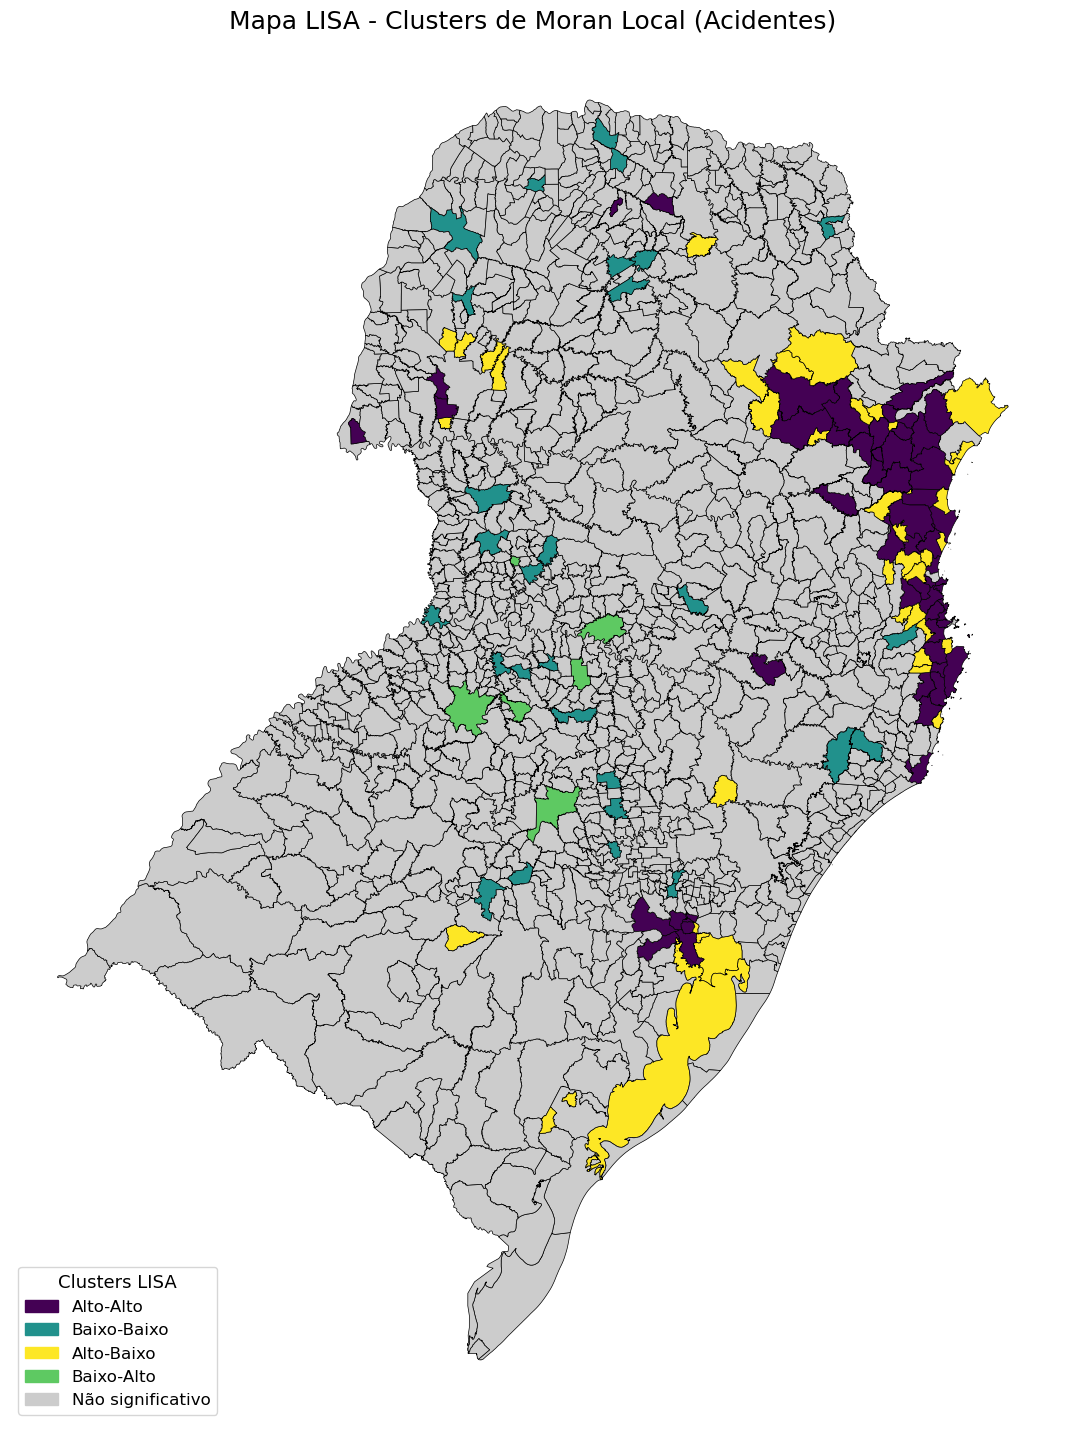

In [54]:
# Cores para os clusters
cores = {
    'Alto-Alto': '#440154',     # Roxo escuro
    'Baixo-Baixo': '#21918c',   # Verde azulado
    'Alto-Baixo': '#fde725',    # Amarelo
    'Baixo-Alto': '#5ec962',    # Verde claro
    'Não significativo': '#cccccc'  # Cinza
}

# Criar mapa
fig, ax = plt.subplots(figsize=(20, 18))
cidades.plot(column='LISA_cluster',
             categorical=True,
             legend=False,
             color=cidades['LISA_cluster'].map(cores),
             linewidth=0.5,
             edgecolor='black',
             ax=ax)

# Criar legendas personalizadas
legenda_patches = [mpatches.Patch(color=color, label=label)
                   for label, color in cores.items()]
plt.legend(handles=legenda_patches,
           title="Clusters LISA",
           loc='lower left',
           fontsize=12,
           title_fontsize=13)

plt.title("Mapa LISA - Clusters de Moran Local (Acidentes)", fontsize=18)
plt.axis('off')
plt.show()
